# CALCULATE ENERGETICS FROM GOTM 1D SIMS

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from netCDF4 import Dataset

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [72]:
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/GOTMOUTPUTS/gotm_1e-5_0p02.nc' # Ruan et al. 2019 case F
N2 = 1e-5
tht = 0.02

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/GOTMOUTPUTS/gotm_2e-5_0p005.nc' # Umlauf et al. 2015 case (diff int vel)
# N2 = 2e-5
# tht = 0.005

S = np.sqrt(N2)/1e-4*tht
print('Slope Burger Number:'+str(S))
ds =  Dataset(filename, 'r')  # Dataset is the class behavior to open the file

u = np.squeeze(ds.variables['u'])
v = np.squeeze(ds.variables['v'])
b = np.squeeze(ds.variables['buoy'])

SP = np.squeeze(ds.variables['P'])
Pb = np.squeeze(ds.variables['Pb'])
VBP = np.squeeze(ds.variables['G'])
EPS = np.squeeze(ds.variables['eps'])
EPSB = np.squeeze(ds.variables['epsb'])
av = np.squeeze(ds.variables['num'])
taub = np.squeeze(ds.variables['taub'])
drag = np.squeeze(ds.variables['drag'][:,0])
tke = np.squeeze(ds.variables['tke'])
time = ds.variables['time'][:]

z1 = ds.variables['z1'][:][0,:,0,0]
z = ds.variables['z'][:][0,:,0,0]
# bpert = b + N2*(z-z[0])
bpert = b - N2*(z)
# bpert = bpert - bpert[:,-1][:,np.newaxis]
MPE = bpert**2/(2*N2)
# MPE = (b-b[:,-1][:,np.newaxis])**2/(2*N2)
MKE = 0.5*((u-1*u[:,-1][:,np.newaxis])**2 + (v-v[:,-1][:,np.newaxis])**2)
sgVBP =-1027*1.4e-7*np.gradient(b, axis=-1)/np.gradient(z)
# sgVBP =-1027*1.3e-6*np.gradient(b, axis=-1)/np.gradient(z)


#try calculating shear prod directly
SP2 = 0.5*(av[:,1:]+av[:,0:-1])*(np.gradient(u, axis=-1)**2 + np.gradient(v, axis=-1)**2)/np.gradient(z)**2

# tx = 0.5*(av[:,2][:,np.newaxis]+av[:,1][:,np.newaxis])*(np.gradient(u, axis=-1))/np.gradient(z)
# ty =  0.5*(av[:,2][:,np.newaxis]+av[:,1][:,np.newaxis])*(np.gradient(v, axis=-1))/np.gradient(z)
tx = (av[:,1][:,np.newaxis])*(np.gradient(u, axis=-1))/np.gradient(z)
ty = (av[:,1][:,np.newaxis])*(np.gradient(v, axis=-1))/np.gradient(z)

arrestind = np.where(taub[1:]/(1030*0.1**2) < 1e-5)[0]
if arrestind.size>0:
    arrestind = arrestind[0]
else:
    arrestind=-1

Slope Burger Number:0.6324555320336759


In [22]:
# Cumulative vertical integrals
nt, nz = MPE.shape
zl = range(0, nz)
SPI = integrate.trapz(SP[:,zl], x=z1[zl], axis=-1)
# SPI = integrate.trapz(SP2, x=z, axis=-1)

VBPI = integrate.trapz(VBP, x=z1, axis=-1)
EPSI = integrate.trapz(EPS[:,zl], x=z1[zl], axis=-1)
EPSBI = integrate.trapz(EPSB[:,zl], x=z1[zl], axis=-1)
MPEI = integrate.trapz(MPE[:,zl], x=z[zl], axis=-1)
TKEI = integrate.trapz(tke, x=z1, axis=-1)
upert = 1*u[:,-1]
MKEMPEI = integrate.trapz((u-upert[:,np.newaxis])*bpert*np.sin(tht), x=z, axis=-1)
# MKEI = integrate.trapz(0.5*((u-1*u[:,-1][:,np.newaxis])**2 + (v-0.1)**2), x=z, axis=-1)
MKEI = integrate.trapz(MKE, x=z, axis=-1)

MPEEPEI = integrate.trapz((0*sgVBP+0.5*(VBP[:,1:]+VBP[:,0:-1]))*np.gradient(bpert, axis=-1)/np.gradient(z), x=z, axis=-1)/N2

# Time cumulative integrals
nt = time.size
tl = range(48,nt)
SPIT = integrate.cumtrapz(SPI[tl], x=time[tl], axis=0, initial=0)
VBIT = integrate.cumtrapz(VBPI[tl], x=time[tl], axis=0, initial=0)
EPSIT = integrate.cumtrapz(EPSI[tl], x=time[tl], axis=0, initial=0)
EPSBIT = integrate.cumtrapz(EPSBI[tl], x=time[tl], axis=0, initial=0)

# DRAGIT = integrate.cumtrapz(0.1*taub[tl]/1030, x=time[tl], axis=0, initial=0)
# DRAGIT = integrate.cumtrapz(drag*np.sqrt(u[:,0]**2+v[:,0]**2)*(v[:,0]*(v[:,0]) + u[:,0]**2), x=time, axis=0, initial=0)
DRAGIT = -integrate.cumtrapz(tx[tl,0]*(u[tl,0]-u[tl,-1]) + ty[tl,0]*(v[tl,0]-v[tl,-1]), x=time[tl], axis=0, initial=0)
MKEMPEIT = integrate.cumtrapz(MKEMPEI[tl], x=time[tl], axis=0, initial=0)
MPEEPEIT = integrate.cumtrapz(MPEEPEI[tl], x=time[tl], axis=0, initial=0)

# MKEIT = integrate.cumtrapz(MKEI, x=time, axis=0, initial=0)
# TKEIT = integrate.cumtrapz(TKEI, x=time, axis=0, initial=0)

## MKE Budgets

'Mean' here means the resolved KE minus the interior velocity. Note that although the initial background flow is purely meridional, it does develop some small amplitude zonal velocities. Removing these seem important.
Thus,

$MKE = \frac{u'^2 + v'^2}{2}$,

where $u' = u - u(z=Lz)$, and $v = v - v(z=Lz)$.

The energy budget is then
\begin{equation}
\frac{\partial MKE}{\partial t} = - SP + \underbrace{u'b'\sin\theta}_{MKE-MPE} + \underbrace{u'(0)\tau_x + v'(0)\tau_y}_{DRAG}
\end{equation}

Text(0.5,0,'Days')

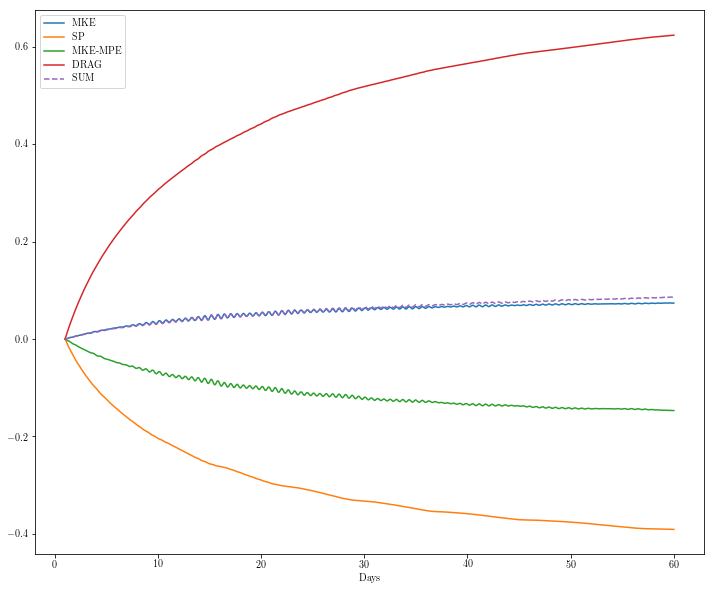

In [4]:
# CUMULATIVE MKE BUDGET
plt.figure(figsize=(12,10))
DeltaMKE = MKEI[tl] - MKEI[tl[0]]
# plt.plot(time/86400, TKEI, label='TKE')
plt.plot(time[tl]/86400, DeltaMKE, label='MKE')

plt.plot(time[tl]/86400, -SPIT, label='SP')
# plt.plot(time/86400, VBIT, label='VBP')
plt.plot(time[tl]/86400, MKEMPEIT, label='MKE-MPE')

# plt.plot(time/86400, -EPSIT/1030, label='DISS')
plt.plot(time[tl]/86400, DRAGIT, label='DRAG')
# plt.plot(time/86400, DRAGIT2, label='DRAG - $v_o$')

plt.plot(time[tl]/86400, (-SPIT+MKEMPEIT+DRAGIT), label='SUM', linestyle='dashed')

plt.legend()
plt.xlabel('Days')

Text(0.5,0,'Days')

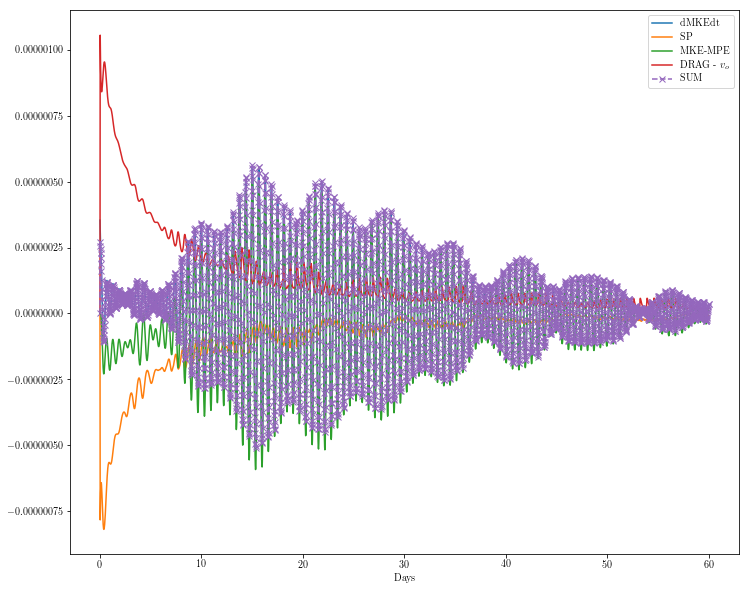

In [5]:
# BUDGET
plt.figure(figsize=(12,10))
dMKEdt = np.gradient(MKEI)/np.gradient(time)
# plt.plot(time/86400, TKEI, label='TKE')
plt.plot(time/86400, dMKEdt, label='dMKEdt')

plt.plot(time/86400, -SPI, label='SP')
# plt.plot(time/86400, VBIT, label='VBP')
plt.plot(time/86400, MKEMPEI, label='MKE-MPE')

# plt.plot(time/86400, -EPSIT/1030, label='DISS')
# plt.plot(time/86400, 0.1*taub/1030, label='DRAG')
# plt.plot(time/86400, drag*np.sqrt(u[:,0]**2+v[:,0]**2)*((v[:,0])*(v[:,0])), label='DRAG', linestyle='dashed')
dragtest = -tx[:,0]*(u[:,0]-u[:,-1]) - ty[:,0]*(v[:,0]-v[:,-1])

# dragtest =  taub[:]*v[tl,0]/1030
plt.plot(time/86400, dragtest, label='DRAG - $v_o$')

plt.plot(time/86400, (-SPI+MKEMPEI+dragtest), label='SUM', linestyle='dashed', marker='x')

plt.legend()
plt.xlabel('Days')
# plt.xlim(20,21)

## MPE Budgets

The mean potential energy budget here is defined in terms of the buoyancy perturbation from the background state. This is the same as the mean APE (as discussed in Umlauf et al. 2015). Thus, definining $b' = b - N^2z$,

$MPE = \frac{b'^2}{2N^2}$, 

and 
\begin{equation}
\frac{\partial MPE}{\partial t} = - \underbrace{u'b'\sin\theta}_{MKE-MPE} + \underbrace{\frac{VBP}{N^2} \frac{\partial b'}{\partial z}}_{EPE-MPE}.
\end{equation}

Note that the EPE-MPE term is term $\mathcal{G}$ in Umlauf et al. 2015.

Text(0.5,0,'Days')

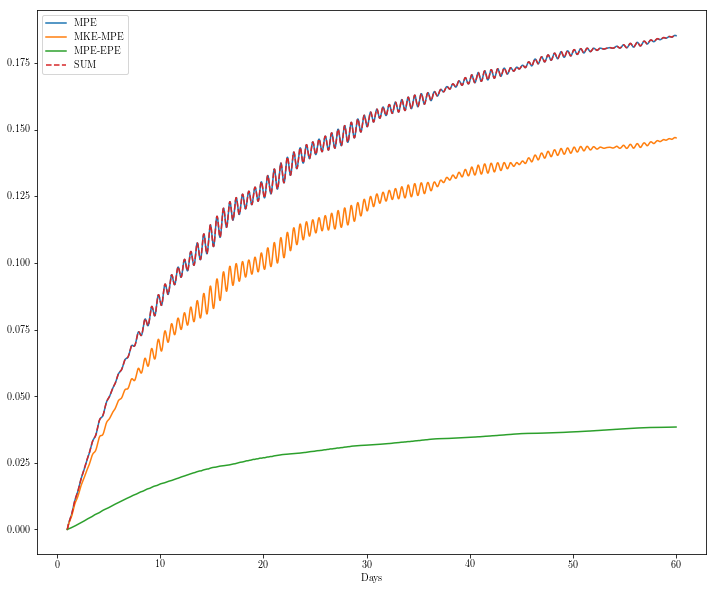

In [6]:
# CUMULATIVE MPE BUDGET
plt.figure(figsize=(12,10))
DeltaMPE = MPEI[tl] - MPEI[tl[0]]
# plt.plot(time/86400, TKEI, label='TKE')
plt.plot(time[tl]/86400, DeltaMPE, label='MPE')

# plt.plot(time[tl]/86400, -SPIT, label='SP')
# plt.plot(time/86400, VBIT, label='VBP')
plt.plot(time[tl]/86400, -MKEMPEIT, label='MKE-MPE')
plt.plot(time[tl]/86400, MPEEPEIT, label='MPE-EPE')
# plt.plot(time/86400, -EPSIT/1030, label='DISS')
# plt.plot(time[tl]/86400, DRAGIT, label='DRAG')
# plt.plot(time/86400, DRAGIT2, label='DRAG - $v_o$')

plt.plot(time[tl]/86400, (-MKEMPEIT+MPEEPEIT), label='SUM', linestyle='dashed')

plt.legend()
plt.xlabel('Days')

Text(0.5,0,'Days')

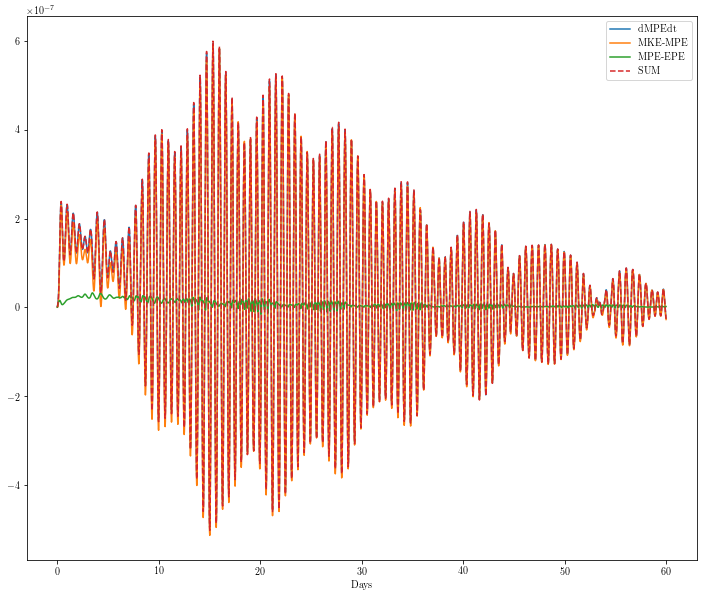

In [7]:
# MPE BUDGET
plt.figure(figsize=(12,10))
dMPEdt = np.gradient(MPEI)/np.gradient(time)
# plt.plot(time/86400, TKEI, label='TKE')
plt.plot(time/86400, dMPEdt, label='dMPEdt')

# plt.plot(time[tl]/86400, -SPIT, label='SP')
# plt.plot(time/86400, VBIT, label='VBP')
plt.plot(time/86400, -MKEMPEI, label='MKE-MPE')
plt.plot(time/86400, MPEEPEI, label='MPE-EPE')
# plt.plot(time/86400, -EPSIT/1030, label='DISS')
# plt.plot(time[tl]/86400, DRAGIT, label='DRAG')
# plt.plot(time/86400, DRAGIT2, label='DRAG - $v_o$')

plt.plot(time/86400, (-MKEMPEI + MPEEPEI), label='SUM', linestyle='dashed')

plt.legend()
plt.xlabel('Days')

## TKE Budget

The TKE budget is a bit trickier here, as these are unresolved (parameterized) quantities. I think it should be,

\begin{equation}
\frac{\partial k}{\partial t} = SP + VBP + \epsilon.
\end{equation}

This appears to be confirmed below, however note that the $\epsilon$ given by the GOTM diagnostic is very finicky, and you have to be careful about the vertical grid (ie it seems that ignoring $i=0$ index is important. Possibly because this represents a flux boundary condition in the subgrid scheme?

(-1e-07, 1e-07)

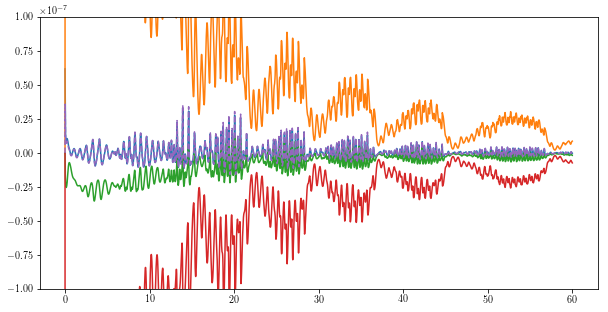

In [147]:
# TKE budget should be dk/dt = P + B - epsilon

TKEI = integrate.trapz(tke[:,1:], axis=-1, x=z1[1:])
dTKEdt = np.gradient(TKEI)/np.gradient(time)
EPSITEST = integrate.trapz(0.5*(EPS[:,2:]+EPS[:,1:-1]), axis=-1, x=z[1:])
EPSITEST = integrate.trapz(EPS[:,1:], axis=-1, x=z)
# EPSITEST = integrate.trapz(EPS[:,0:], axis=-1, x=z1)/5

SPITEST = integrate.trapz(SP[:,1:], axis=-1, x=z)
VBPITEST = integrate.trapz(VBP[:,1:], axis=-1, x=z)

plt.figure(figsize=(10, 5))
plt.plot(time/86400, dTKEdt)
plt.plot(time/86400, SPITEST)
plt.plot(time/86400, VBPITEST)
plt.plot(time/86400, -EPSITEST)
plt.plot(time/86400, SPITEST+VBPITEST-EPSITEST, linestyle='dashed')
plt.ylim(-1e-7, 1e-7)

## Turbulent buoyancy budget

The subgrid turbulent buoyancy budget is,
\begin{equation}
\frac{\partial k_b}{\partial t} = - VBP - \underbrace{\frac{VBP}{N^2} \frac{\partial b'}{\partial z}}_{EPE-MPE} + \epsilon_b.
\end{equation}

Note that (I believe) the subgrid closure assumes $\partial k_b/\partial t = 0$. I think that the GOTM output is such that the term $P_b$ in the diagnostics represents the total production of buoyancy variance (ie the sum of the first two terms on the RHS), which then has to balance the dissipation. This appears to be consistent with the calculations below. However, note that the GOTM diagnostic $\epsilon_b$ does not close this budget. As in the TKE budget I will just go with the assumption that $\epsilon_b = P_b$ as this seems most consistent with the below analysis and the findings of Umlauf et al. 2015. Should come back to this and confirm.

(-1e-08, 1e-08)

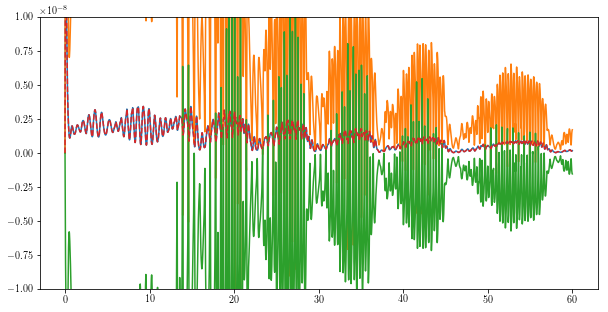

In [131]:
TKEI = integrate.trapz(tke[:,1:], axis=-1, x=z1[1:])
dTKEdt = np.gradient(TKEI)/np.gradient(time)
EPSBITEST = integrate.trapz(EPSB[:,0:]/(2*N2), axis=-1, x=z1)
PBITEST = integrate.trapz(Pb[:,0:]/(N2), axis=-1, x=z1)
VBPITEST = integrate.trapz(VBP[:,1:], axis=-1, x=z)
MPEEPEI = integrate.trapz((-0*sgVBP+0.5*(VBP[:,1:]+VBP[:,0:-1]))*np.gradient(bpert, axis=-1)/np.gradient(z), x=z, axis=-1)/N2

plt.figure(figsize=(10, 5))
plt.plot(time/86400, PBITEST)
plt.plot(time/86400, -VBPITEST)
# plt.plot(time/86400, -EPSBITEST)
plt.plot(time/86400, -MPEEPEI)
plt.plot(time/86400, -VBPITEST-MPEEPEI, linestyle='dashed')
plt.ylim(-1e-8, 1e-8)

## Mixing Efficiencies

There are several possible definitions of mixing efficiency that can be considered. All the below are assumed to be vertical integrals.

The first is the change in mean potential energy to the cumulative dissipation. Note that if full Ekman arrest occurs this should become steady.

\begin{equation}
Q = \frac{MPE(t)}{\int_0^t \epsilon dt}
\end{equation}

The next is the ratio of cumulative dissipation of buoyancy variance to cumulative energy dissipation,

\begin{equation}
\Gamma = \frac{\int_0^t \epsilon_b dt}{\int_0^t \epsilon dt}
\end{equation}




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


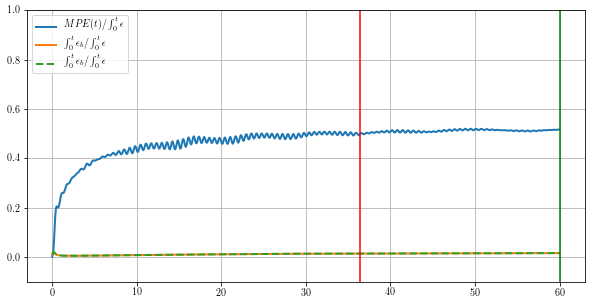

In [139]:
# MPEBACK = (b-b[:,-1][:,np.newaxis])**2/(2*N2)
tl = range(0, nt)
zl = 1
MPE = bpert**2/(2*N2)
# MPEI = integrate.trapz(MPE[:,zl:], x=z[zl:], axis=-1)
# # zl = 0
# EPSIT = integrate.cumtrapz(integrate.trapz(EPS[tl,zl:], axis=-1, x=z1[zl:]), x=time[tl], initial=0)
# zl = 0
# EPSBIT = integrate.cumtrapz(integrate.trapz(Pb[tl,zl:]/(1), axis=-1, x=z1[zl:]), x=time[tl], initial=0)
# zl = 0
# VBIT = integrate.cumtrapz(integrate.trapz(VBP[tl,zl:], axis=-1, x=z1[zl:]), x=time[tl], initial=0)

zl = 1
Qratio = integrate.trapz(MPE[:,zl:], x=z[zl:], axis=-1)/integrate.cumtrapz(integrate.trapz(EPS[tl,zl:], axis=-1, x=z1[zl:]), x=time[tl], initial=0)
zl = 1
Gammaratio = integrate.cumtrapz(integrate.trapz(Pb[tl,zl:]/(N2), axis=-1, x=z1[zl:]), x=time[tl], initial=0)/integrate.cumtrapz(integrate.trapz(EPS[tl,zl:], axis=-1, x=z1[zl:]), x=time[tl], initial=0)

# MPEBACKI = integrate.trapz(MPEBACK, axis=-1, x=z)
# Ratio of MPE to dissipation
plt.figure(figsize=(10, 5))
plt.plot(time[tl]/86400, Qratio, linewidth=2, label='$MPE(t)/\int_0^t \epsilon$') # This is Q in Umlauf et al. 2015, ie ratio of gain of MPE to dissipated energy
# plt.plot(time[tl]/86400, 1+(MPEBACKI[tl]-1*MPEBACKI[tl[0]])/EPSIT) # This is Q in Umlauf et al. 2015, ie ratio of gain of MPE to dissipated energy

# Ratio of VBP to dissipation
plt.plot(time[tl]/86400, EPSBIT/(N2*EPSIT),linewidth=2, label='$\int_0^t \epsilon_b/\int_0^t \epsilon$') # This is Gamma in Umlauf et al. 2015, ratio of dissipated buoyancy variance to Energy diss
plt.plot(time[tl]/86400, Gammaratio,linewidth=2,linestyle='dashed', label='$\int_0^t \epsilon_b/\int_0^t \epsilon$') # This is Gamma in Umlauf et al. 2015, ratio of dissipated buoyancy variance to Energy diss

# plt.plot(time[tl]/86400, -VBIT/(EPSIT),linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # Ratio of cumulative VBP to EPS

plt.axvline(time[arrestind]/86400, color='g')
plt.axvline(2*np.pi/1e-4*50/86400, color='r')

plt.ylim(-0.1, 1)
plt.legend()
plt.grid()

## EXTRAS

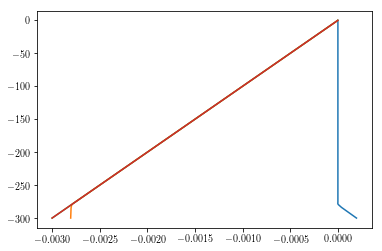

In [9]:
ts = 48
plt.plot(bpert[ts,:], z)
plt.plot(b[ts,:], z)
plt.plot(N2*z, z)
plt.plot(-bpert[ts,:]+b[ts,:], z)

In [10]:
plt.plot(time/86400, MPEBACKI-MPEBACKI[0])
plt.plot(time/86400, MPEI - MPEI[0])

NameError: name 'MPEBACKI' is not defined

In [ ]:
EPS[tl, zl].shape

In [ ]:
z[zl]

In [ ]:
plt.plot(time/86400, np.trapz(u[:,1:-10],x=z[1:-10], axis=-1))

In [ ]:
plt.plot(u[-1,:]-upert[-1,np.newaxis], z)

In [ ]:
plt.plot(av[:,1])

In [ ]:
MPEI[1]/EPSIT[1]

In [ ]:
zl

In [ ]:
nz

In [ ]:
2*2*np.pi/86400*np.sin(43.44*np.pi/180)

In [ ]:
 9.81*0.0000010193679/1e-4

In [ ]:
# sgVBP =1e-5*np.gradient(b, axis=-1)/np.gradient(z)
plt.plot(integrate.trapz(0.5*(VBP[:,1:]+VBP[:,0:-1])*np.gradient(bpert, axis=-1)/np.gradient(z), axis=-1, x=z))
plt.plot(integrate.trapz(sgVBP*1000*np.gradient(bpert, axis=-1)/np.gradient(z), axis=-1, x=z))

In [ ]:
plt.plot(v[:,-1])

In [ ]:
plt.plot(integrate.trapz(u[:,200:], axis=-1, x=z[200:]))

In [ ]:
integrate.trapz(integrate.trapz(u[:,200:], axis=-1, x=z[200:])/np.abs(z[200]), x=time)*N2*tht

In [ ]:
time[1]-time[0]

In [ ]:
30*6

In [ ]:
# 